In [ ]:
# Centroid Pieces

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from import_casa import casa

In [3]:
from gensim.models import FastText

In [4]:
path = casa.get_data_path() / "eda/spm/sp_vectors.model"
model = FastText.load(str(path))
model.wv.vectors.shape

[INFO] 2020-12-18 15:07:13,034 gensim.utils: loading FastText object from /Users/seantyh/langon/casa/data/eda/spm/sp_vectors.model
[INFO] 2020-12-18 15:07:13,104 gensim.utils: loading wv recursively from /Users/seantyh/langon/casa/data/eda/spm/sp_vectors.model.wv.* with mmap=None
[INFO] 2020-12-18 15:07:13,105 gensim.utils: loading vectors_ngrams from /Users/seantyh/langon/casa/data/eda/spm/sp_vectors.model.wv.vectors_ngrams.npy with mmap=None
[INFO] 2020-12-18 15:07:13,558 gensim.utils: setting ignored attribute vectors_ngrams_norm to None
[INFO] 2020-12-18 15:07:13,559 gensim.utils: setting ignored attribute vectors_norm to None
[INFO] 2020-12-18 15:07:13,559 gensim.utils: setting ignored attribute vectors_vocab_norm to None
[INFO] 2020-12-18 15:07:13,559 gensim.utils: setting ignored attribute buckets_word to None
[INFO] 2020-12-18 15:07:13,560 gensim.utils: loading vocabulary recursively from /Users/seantyh/langon/casa/data/eda/spm/sp_vectors.model.vocabulary.* with mmap=None
[INFO

(5885, 100)

## Hierarchical Clustering

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import seaborn as sns
from matplotlib import pyplot as plt

In [34]:
M = model.wv.vectors
distM = pdist(M, metric='correlation')
print(distM) # return a condensed distance matrix 

[0.63116994 0.83663431 0.65747296 ... 0.93373285 0.84845195 1.55661941]


In [16]:
ldata = linkage(distM, method='complete')

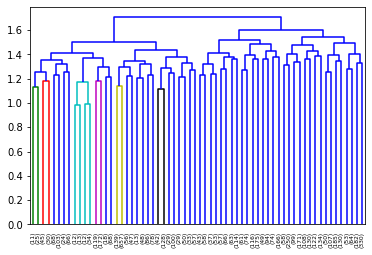

In [85]:
dn = dendrogram(ldata, truncate_mode='level', p=5)

In [86]:
cl_order = dn["leaves"]

In [87]:
dM = squareform(distM)

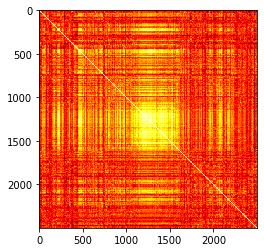

In [38]:
plt.imshow((1-dM)[cl_order[:2500],:][:, cl_order[:2500]], cmap="hot")

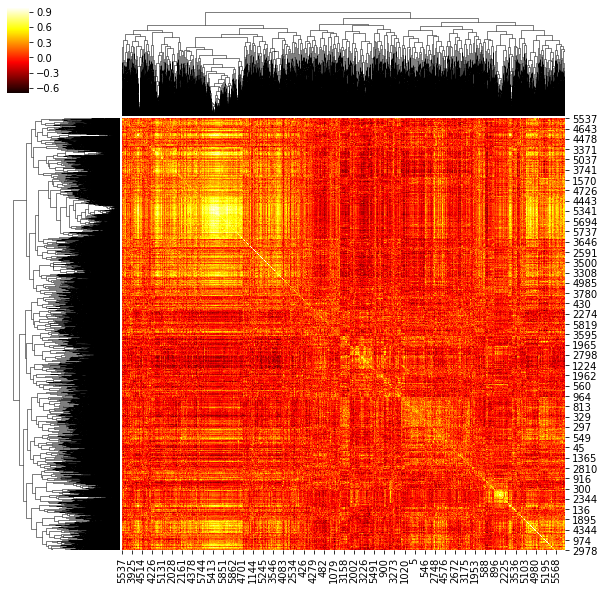

In [40]:
# no reordering
clsmap = sns.clustermap(data=1-dM, row_linkage=ldata, col_linkage =ldata, method = 'complete', cmap="hot")
# clsmap.savefig("cls_map.jpg")

## Construct Centroid Pieces from clustering

In [137]:
def find_centroid(vectors):
    if len(vectors) == 1:
        return 0
    vec_matrix = np.vstack(vectors)
    centroid_vec = np.mean(vec_matrix, 0)
    corrs = [np.corrcoef(x, centroid_vec)[0,1] for x in vec_matrix]
    max_corr_idx = np.argmax(corrs)
    return max_corr_idx

In [150]:
from collections import defaultdict
clusters = defaultdict(list)
cluster_labels = fcluster(ldata, t=1, criterion='distance')
for word_i, cluster_i in enumerate(cluster_labels):
    clusters[cluster_i].append(model.wv.index2word[word_i])

print(f"Total {len(clusters)} Clusters")
data_items = []
for idx in sorted(clusters.keys(), key=lambda x: -np.mean([len(x)-1 for x in clusters[x]])):
    words = clusters[idx]
    cluster_idx = idx
    cluster_size = len(words)
    if len([x for x in words if len(x)>1]) < 3:
        continue
    centroid_id = find_centroid([model.wv.get_vector(w) for w in words])
    word_sample = ' '.join(sorted(words, key=lambda x: -len(x))[:10])
    
    centroid = words[centroid_id]
    print(f"{cluster_idx:03d}({cluster_size:>3d}): [{centroid}] {word_sample}")
    data_items.append([cluster_idx, cluster_size, centroid, " ".join(words)])

Total 310 Clusters
274( 19): [bile] Mobile mobile riDay Video obile line Line LINE Hami ideo
118( 21): [中華電信] 台灣大哥大 。中華電信 中華電信的 台灣之星的 中華電信 台灣之星 亞太電信 遠傳電信 亞太5G 遠傳5G
182( 19): [12pro] iphone12 iphone 12Pro 12pro 128G mini Pro pro 128 i12
270( 17): [Pixel] Android Google google Pixel pixel droid ixel 不支援 支援 顯示
192( 31): [12、iPhone] 12、iPhone iPhone12 的iPhone 、iPhone #iPhone iPhone 12系列 網路門市 實體門市 預約登記
159( 19): [1399元] 綁約48個月 1399元 綁48個月 1399 5G資費 48個月 599元 999元 購機方案 的資費
162( 25): [24個月] 不限速吃到飽 上網吃到飽 4G吃到飽 5G吃到飽 30個月 24個月 吃到飽的 12個月 吃到飽 一個月
157( 36): [199] LM111 台星188 LM211 亞太11 1111 等雙11 2699 1599 /211 台星88
268( 22): [LTE] vowifi volte WIFI wifi sim卡 SIM卡 eSIM esim LTE SIM
158( 33): [3000] 月付1799 月租1799 1799 300元 3500 1000 1800 3600 100元 2000
156( 18): [方案] 499吃到飽 中華499 資費方案 5G方案 優惠方案 續約方案 499 的方案 高資費 低資費
183( 15): [hone] [手機資訊] phone fone HONE hone 換電池 one [手機 ONE 搭配
091( 11): [Pods] AirPods irPods ———— Pods ods —— 包 含 — 🔸
204( 27): [.....] ........ ...... ..... .... ... 了嗎? ??? 我也是 的嗎? 嗎

In [144]:
import pandas as pd

In [147]:
spm_centroids = pd.DataFrame(data_items, columns="cluster_idx,cluster_size,centroid,words".split(","))

In [152]:
spm_centroids.to_csv(casa.get_data_path() / "eda/spm/spm_centroids.csv")